In [1]:
import sys
# sys.path.insert(0, '/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP')
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)



TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_device(device)
print(f'Device is: {device}')

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False


# with open('data/processed_data.pkl', 'wb') as f:
#     pickle.save(f)

# To compare with samuale use:
# save_pickle('pietro_data', **{'K_pietro':K, 'K_tilde_pietro':K_tilde})    

Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


## Parameters of the training

In [2]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

cellid  = 8             # Choose cell
ntilde  = 50            # Number of xtilde
kernfun = 'acosker' # Choose kernel function

nEstep      = 3         # Total number of E-steps iterations. Update on the variational parameters m and V, plus the parameters f_param of the link function
nFparamstep = 5         # Number of iterations for the update of the f params of the link function for EACH E-step iteration
nMstep      = 3         # Total number of M-steps iterations. Update on the Hyperparameters of the kernel function
maxiter     = 7         # Iterations of the optimization algorithm comprising M and E steps

## Import the dataset and preprocess


In [3]:
# Import the data

# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training data
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Concatenate Xtrain and Xval if not using validation set 
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)
# X = X_train
# R = R_train

# Choose a cell
r = R[:,cellid] # shape (nt,) where nt is the number of trials

# Reshape images to 1D vector
n_px_side = X.shape[1] # 108   
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
# If X_val is being used, reshape it
# X_val = torch.reshape(X_val, ( X_val.shape[0], X_val.shape[1]*X_val.shape[2])) # shape (n x val, 11664)=(nt, nx)

if rand_xtilde == True:
    ntilde_indices = torch.randint(0, X.shape[0], (ntilde,))
else:
    ntilde_indices = torch.arange(0,ntilde, dtype=torch.int64)

xtilde = X[ntilde_indices,:]


## Choose starting values of parameters

In [4]:
# In this code the learnt hyperparameters are the one in the dictionary 'theta'
# One can set them direcly or let generate_theta() set them based on the training set STAs
# To override the choice of generate_theta() just give theta as input 

# If one wants to compare the hyperparemeters set in Matthews's / Samuels's code one has to set
# logbetasam : and transform it to logbetaexpr with the function fromlogbetasam_to_logbetaexpr
# logrhosam  : and transform it to logrhoexpr with the function fromlogrhosam_to_logrhoexpr
# logsigma_0 : and transform it to sigma_0 exponetiating it

# logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
# logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

# Alternatively one can directly set the hyperparameters to the values in the dictionary 'theta' below
# logbetaexpr = torch.tensor(4.65)
# logrhoexpr = torch.tensor(4.3)

# Or set them as beta and rho
beta = torch.tensor(0.032)
rho  = torch.tensor(0.076)
# beta = torch.tensor(0.022)
# rho  = torch.tensor(0.0045)
logbetaexpr = -2*torch.log(2*beta)
logrhoexpr  = -torch.log(2*rho*rho)

# Samuele's code set the log of sigma
logsigma_0 = torch.tensor(0) 
sigma_0    = torch.exp(logsigma_0)

# Amp is not present in Matthews original code
Amp = torch.tensor(1.0) 

# Center of receptive field
# eps_0x = torch.tensor(0.2)
# eps_0y = torch.tensor(-0.02)
eps_0x = torch.tensor(0.0001)
eps_0y = torch.tensor(0.0001)

# Hypermarameters are expected to be 0-dimensional tensors
theta = {'sigma_0'  : sigma_0,     'Amp': Amp,
        'eps_0x'    : eps_0x ,     'eps_0y'   : eps_0y, 
        '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr }

# Set the gradient of the hyperparemters to be updateable 
for key, value in theta.items():
    # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nMstep=0)
    # if key == 'eps_0x' or key == 'eps_0y':
        # continue
    theta[key] = value.requires_grad_()

# Generate the hyperparameters tuple
# If hyperparameters are set manually:
hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)


A        = torch.tensor(0.007)
logA     = torch.log(A)
# lambda0  = torch.tensor(0.31)
lambda0  = torch.tensor(1)
f_params = {'logA': logA, 'loglambda0':torch.log(lambda0)}

# f_params = {'logA': logA, 'tanhlambda0':torch.tanh(lambda0)}
# f_params = {'logA': logA, 'lambda0':torch.tensor(0.31)}

for key, value in f_params.items():
    f_params[key] = value.requires_grad_()

args = {
        'cellid': cellid,                       # sending also cellid to the fit function to make sure we dont lose track of it
        'ntilde':  ntilde,
        'maxiter': maxiter,
        'nMstep':  nMstep,
        'nEstep':  nEstep,
        'nFparamstep': nFparamstep,
        'kernfun': kernfun,
        'n_px_side': n_px_side,
        'display_prog':  False,
        'hyperparams_tuple': hyperparams_tuple,
        'f_params': f_params,
        'xtilde': xtilde,
        'm': torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
        #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
    }


updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 5.4977
updated -log2rho2 to 4.4609


## Fit the model
Also returns a tracking dictionary for important values

In [ ]:
theta_fit, f_params_fit, m_b_fit, V_b_fit, C_fit, mask_fit, K_tilde_b_fit, K_tilde_inv_b_fit, B, fit_parameters, values_track_fit, err_dict = utils.varGP(X, r, **args)

# Save the model. All of the matrices are projected in the eigenspace of big eigenvalues of K_tilde. Indicated by _b
model_b = {
    'theta': theta_fit,
    'f_params': f_params_fit,
    'm_b': m_b_fit,
    'V_b': V_b_fit,
    'C'  : C_fit,
    'mask': mask_fit,
    'K_tilde_inv_b': K_tilde_inv_b_fit,
    'K_tilde_b': K_tilde_b_fit,
    'B': B,
    'values_track': values_track_fit,
}

for key in fit_parameters.keys():
    model_b[key] = fit_parameters[key]

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

utils.save_model(model_b, 'models/cell8')

 Before overloading
 Hyperparameters have been SET as  : beta = 0.0586, rho = 0.0293
 Samuele hyperparameters           : logbetasam = 4.9822, logrhosam = 7.0617

 After overloading
 Dict of learnable hyperparameters : sigma_0 = 1.0000, eps_0x = 0.0000, eps_0y = 0.0000, -2log2beta = 4.2891, -log2rho2 = 6.3685, Amp = 1.0000
 Hyperparameters from the logexpr  : beta = 0.0586, rho = 0.0293
 Samuele hyperparameters           : logbetasam = 4.9822, logrhosam = 7.0617
Initialization took: 0.0529 seconds

*Iteration*: 0 E-step took: 0.3624s, M-step took: 0.0648s
*Iteration*: 1 E-step took: 0.2043s, M-step took: 0.0466s
*Iteration*: 2 E-step took: 0.2114s, M-step took: 0.0591s
*Iteration*: 3 E-step took: 0.2029s, M-step took: 0.0463s
*Iteration*: 4 E-step took: 0.1840s, M-step took: 0.0472s
*Iteration*: 5 E-step took: 0.1855s, M-step took: 0.0478s
*Iteration*: 6 E-step took: 0.2282s, M-step took: 0.0481s
Final Loss: 2816.7429
      time for final loss computation: 0.0093 s
Total time for GP:  

In [ ]:
model_b = utils.load_model('models/cell8')

### Plot the Loss and Hyperparameters

`VarGP` returns 2 dictionaries with the following structure:

- `values_track`:
  - `loss_track`:
    - `logmarginal`
    - `loglikelihood`
    - `KL`
  - `theta_track`:
    - `sigma_0`
    - `eps_0x`
    - `eps_0y`
    - `-2log2beta`
    - `-log2rho2`
    - `Amp`
  - `f_par_track`:
    - `logA`
    - `loglambda0`


- `fit_parameters`:
  - `maxiter`,
  - `nMstep`,
  - `nEstep`,
  - `kernfun`,
  - `cellid`,
  - `MIN_TOLERANCE`,
  - `EIGVAL_TOL`

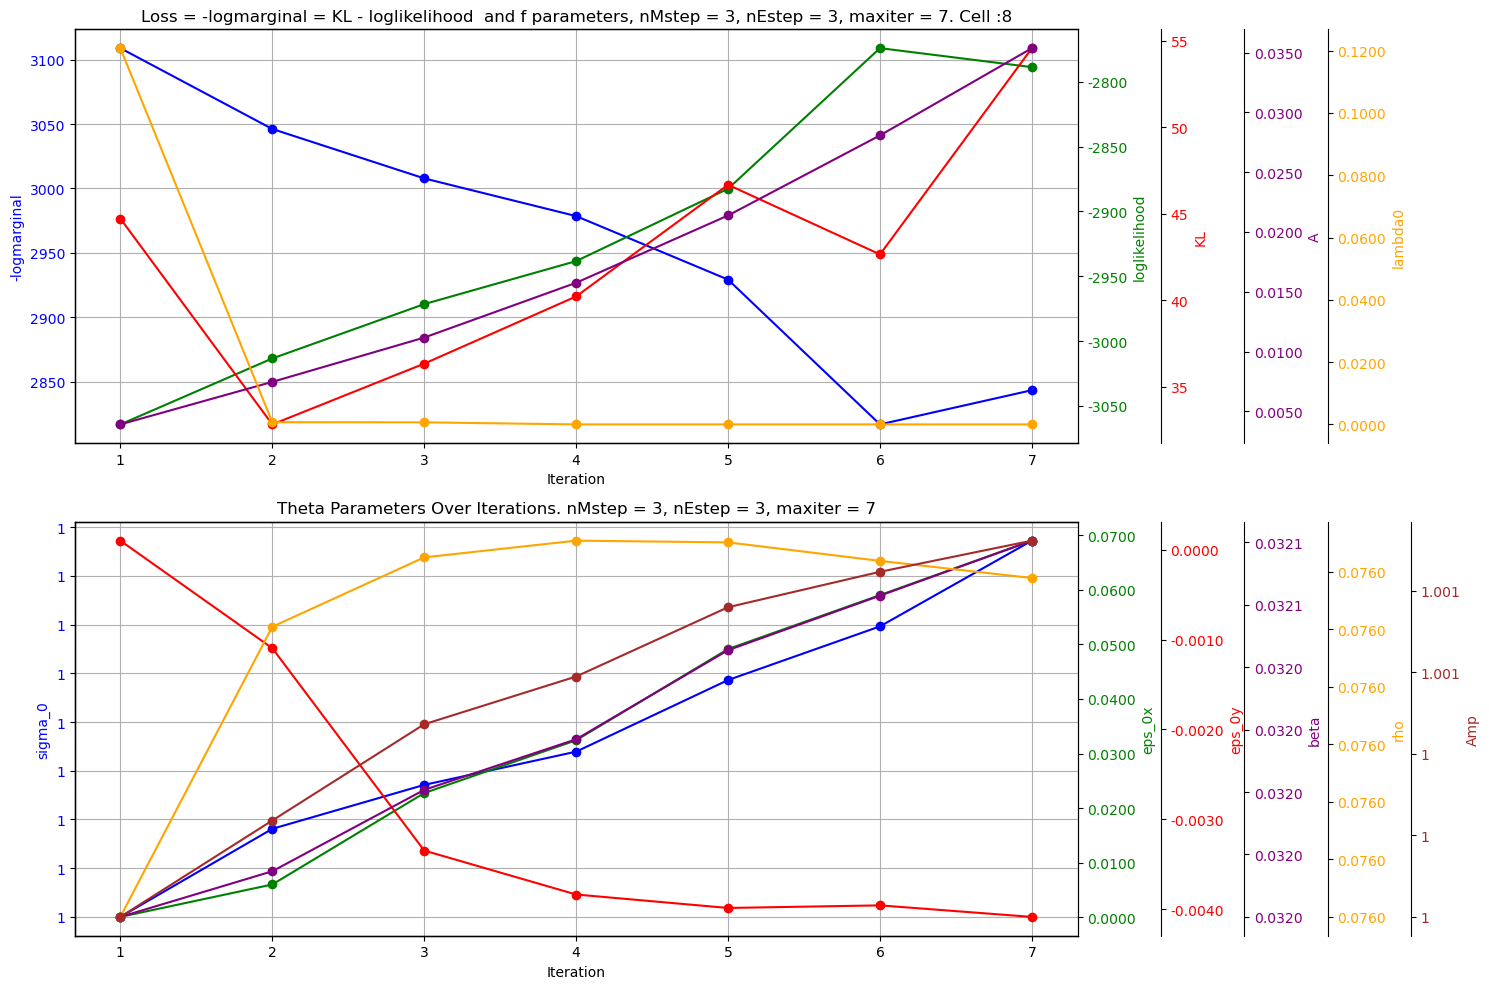

In [8]:
xlim = None
ylim_lambda0 = None
utils.plot_loss_and_theta_notebook(model_b, figsize=(15,10), xlim=xlim, ylim_lambda0=ylim_lambda0, )#ylim_logmarg=(0, 5000))

## Evaluate the model on the test set using the explained variance and plot it



 Pietro's model: R2 = 0.82 ± 0.02 Cell: 8 maxiter = 7, nEstep = 3, nMstep = 3 



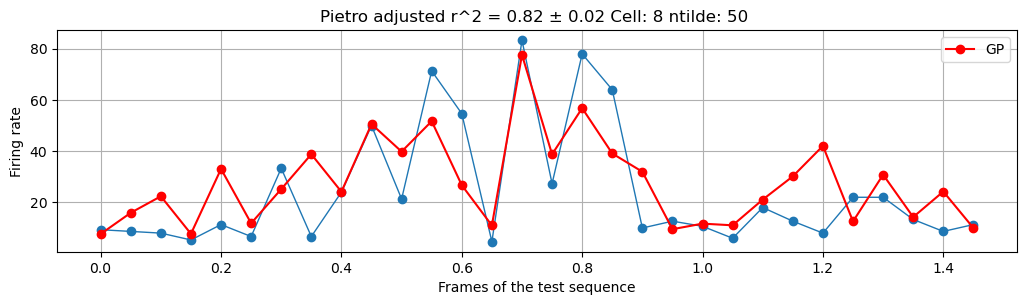

In [9]:
torch.set_grad_enabled(False)


# Predict and test
R_test_cell, R_pred_cell, r2, sigma_r2 = utils.test(X_test, R_test, xtilde, **model_b )


R_test_cell = R_test_cell.cpu().numpy()
R_pred_cell = R_pred_cell.cpu().numpy()
r2          = r2.cpu().numpy()
sigma_r2    = sigma_r2.cpu().numpy()

# Plot results after putting on cpu, numpy.
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(5, 5,
            left=0.1, right=0.9, bottom=0.1, top=0.9,
            wspace=0.3, hspace=0.7)
dt = 0.05
time_values = dt * np.arange( len(R_pred_cell) )
ax = fig.add_subplot(gs[3:, :])
ax.plot(time_values, np.mean(R_test_cell, axis=0) / 0.05, 'o-', linewidth=1)

ax.plot(time_values, R_pred_cell / 0.05, 'o-', color='red', label='GP')
# ax.errorbar(time_values, R_predicted / 0.05, yerr=np.sqrt(sigma2_f[:,0].cpu()) / 0.05, color='red')
# ax.legend(['data', 'GP'], loc='upper right', fontsize=14)
txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Cell: {cellid} ntilde: {ntilde} '
ax.set_title(f'{txt}')
ax.set_ylabel('Firing rate')
ax.set_xlabel('Frames of the test sequence')
ax.grid(axis='both')
# plt.grid()
plt.legend()
plt.show()
plt.close()


a=1